# <img style="float: left; padding-right: 50px, width 45px"  src="https://miro.medium.com/max/1280/1*tHXPVLP294z8dcZwkL3wHw.png" width="250" height="50" > <br/><br/>
## Viewing TBR Over Time
 
**Team: RST-A**<br/>
**Date**: Q3 2022<br/>
**Authors**: Zac Cote <br/>

<hr style="height:2pt" >

In [1]:
# Install potentially missing packages in SageMaker

# import sys
# ! {sys.executable} -m pip install tensorflow
# ! {sys.executable} -m pip install shap
# ! {sys.executable} -m pip install keras
# ! {sys.executable} -m pip install graphviz
# ! {sys.executable} -m pip install pyathena
# ! {sys.executable} -m pip install snappy
# ! {sys.executable} -m pip install xgboost

In [2]:
import datetime as dt
from datetime import timedelta

import matplotlib.pylab as plt
import seaborn as sns

import pandas as pd
import boto3
import os
import io
import numpy as np
import math
import time

import sys
import pyarrow
import snappy

from itertools import chain
from functools import reduce
from pyathena import connect
from os import path

In [3]:
# Establishing S3 Data Directory

data_dir = 's3://cotezach-prod/query_results'

In [4]:
# Function to Directly Query Athena Tables

def athena_conn(query, s3_dir = 's3://aws-athena-query-results-038954691342-us-east-1/', region = 'us-east-1'):
    """Return a SQL query from Athena into a pandas dataframe."""
    
    # Define connection to Athena
    conn = connect(s3_staging_dir = s3_dir,
                   region_name = region)
    
    # Query Athena and return to df
    df = pd.read_sql(query, conn)
    
    return df

In [5]:
# Fetch from / Write to S3 Functions

def fetch_s3_from_file(path_to_file):
    
    client = boto3.client('s3')
    obj2 = client.get_object(Bucket = 'cotezach-prod', Key = path_to_file)
    df = pd.read_csv(obj2['Body'])
    return df


def write_results_s3(dataframe, sand_box, path):
    data_string = dataframe.to_csv()
    resource = boto3.resource('s3')
    object = resource.Object(sand_box, path) # Select folder and file name in your path in S3
    object.put(Body = data_string)

In [6]:
START_DATE = '2020-01-01'
END_DATE = '2022-12-31'
CHUNK_SIZE = 30

#code to pull and save data
def date_range_list(start, end, chunk_size):
    start = dt.datetime.strptime(start,"%Y-%m-%d")
    end = dt.datetime.strptime(end,"%Y-%m-%d")
    diff = dt.timedelta(chunk_size)
    intv = math.ceil((end  - start ) / diff)
    for i in range(intv):
        yield (start + diff * i).strftime("%Y-%m-%d")
    yield end.strftime("%Y-%m-%d")

def run_query(query_name, file_name, start=START_DATE, end=END_DATE, chunk_size=CHUNK_SIZE):
#    query_root = './queries/'
    data_path = './data/{}_{}_{}.csv'.format(file_name, start, end)
    if path.exists(data_path):
        df = pd.read_csv(data_path)
    elif start==None:
        query2 = query_name.format(start_date=start, end_date=end)
        df = athena_conn(query2)
    else:
        date_list = list(date_range_list(start, end, chunk_size))
        dfs = []
        for start, end in zip(date_list, date_list[1:]):
            print('Pulling data between {} and {}\r'.format(start, end), end='')
            query2 = query_name.format(start_date=start, end_date=end)
            df = athena_conn(query2)
            dfs.append(df)
        df = pd.concat(dfs)
        write_results_s3(df,'cotezach-prod','query_results/{}_{}_{}.csv'.format(file_name, start, end))
    return df

## Pulling TBR Data to Visualize

In [7]:
# Querying Building Information

query = '''

-- Building Information

WITH fc_info as (
            SELECT
             fc.warehouse AS building
            ,fc.region as region
            ,fc.timezone AS time_zone
            ,fc.building_type
            ,SPLIT_PART(z.drive_type,'-',2) as drive_type
            FROM ar_metadata.warehouses_v3_prod_v fc
            LEFT JOIN ar_metadata.zones_v3_prod_v z ON fc.warehouse = z.warehouse
            )
            
SELECT DISTINCT
     fc.building as site
    ,fc.region
    ,CASE WHEN fc.building_type = 'Gen11' THEN 'GEN11'
          WHEN fc.building_type = 'Sub Same Day Prime' THEN 'SSD'
          ELSE fc.building_type END as building_type
    ,fc.drive_type
    ,b.first_pick_data as pick_start
    ,b.first_stow_data as stow_start
FROM fc_info fc
JOIN aggregated_metrics.building_launch_info_v b on fc.building = b.site
WHERE 1=1
    AND fc.building IS NOT NULL
    AND fc.drive_type IS NOT NULL
    AND b.first_pick_data IS NOT NULL
    AND fc.drive_type IN ('H','G')
    -- AND fc.region IN ('NA','EU','NRT') '''

fc_data = athena_conn(query)

In [8]:
fc = fc_data

# Sorting by kiva_system_key & Datetime
fc = fc.sort_values(['site','drive_type','building_type','pick_start'], ignore_index = True)

# Pick Start as Datetime
fc['pick_start'] = pd.to_datetime(fc['pick_start'])

# Creating Launch Year Field
fc['launch_year'] = pd.DatetimeIndex(fc['pick_start']).year

# Trimming DF
fc = fc[['site','region','building_type','drive_type','pick_start','launch_year']]

fc.head()

,site,region,building_type,drive_type,pick_start,launch_year
0,ABQ1,NA,GEN11,H,2021-10-25,2021
1,ACY1,NA,Sortable,H,2018-12-29,2018
2,AGS1,NA,GEN11,H,2021-08-24,2021
3,AGS2,NA,Quick Deploy,H,2020-10-09,2020
4,AKC1,NA,Sortable,H,2020-11-04,2020


In [9]:
# Querying Pick Rate/Takt Data

query = '''

-- NACF & EUCF Query
 
select
    n.region,
    n.building,
    n.pt_date,
    SUM(n.stow_resolutions)*1.0 as total_stows,
    SUM(tron_high_confidence_agreements)*1.0 as hc_agreements,
    SUM(tron_high_confidence_agreements)*1.0/nullif(SUM(tron_high_confidence_audits)*1.0,0) as ML_Accuracy,
    SUM(tron_high_confidence_audits)*1.0 as hc_audits,
    SUM(high_confidence_count)*1.0 as hc_count,
    SUM(tron_low_confidence_agreements)*1.0 as lc_agreements,
    SUM(tron_low_confidence_audits)*1.0 as lc_audits,
    SUM(low_confidence_count)*1.0 as lc_count,
    SUM(multiple_events)*1.0 as multiple_events
from aggregated_metrics_nike.ids_5min_aggregated_metrics_v n
where n.pt_date BETWEEN DATE('{start_date}') AND DATE('{end_date}')
AND n.region IN ('NA','EU')
group by 1,2,3
 
UNION ALL
 
-- NRT Query
 
select
    n.region,
    n.building,
    n.pt_date,
    SUM(n.stow_resolutions)*1.0 as total_stows,
    SUM(tron_high_confidence_agreements)*1.0 as hc_agreements,
    SUM(tron_high_confidence_agreements)*1.0/nullif(SUM(tron_high_confidence_audits)*1.0,0) as ML_Accuracy,
    SUM(tron_high_confidence_audits)*1.0 as hc_audits,
    SUM(high_confidence_count)*1.0 as hc_count,
    SUM(tron_low_confidence_agreements)*1.0 as lc_agreements,
    SUM(tron_low_confidence_audits)*1.0 as lc_audits,
    SUM(low_confidence_count)*1.0 as lc_count,
    SUM(multiple_events)*1.0 as multiple_events
from aggregated_metrics_nike.ids_5min_aggregated_metrics_nrt_v n
where n.pt_date BETWEEN DATE('{start_date}') AND DATE('{end_date}')
AND n.region IN ('NRT')
group by 1,2,3 '''

# ids_data = athena_conn(query)

In [10]:
ids_data = run_query(query, 'ids_data', chunk_size=30, start = '2022-01-01', end = '2023-03-05')

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/boto3/compat.py:88: PythonDeprecationWarning: Boto3 will no longer support Python 3.6 starting May 30, 2022. To continue receiving service updates, bug fixes, and security updates please upgrade to Python 3.7 or later. More information can be found here: https://aws.amazon.com/blogs/developer/python-support-policy-updates-for-aws-sdks-and-tools/
  warnings.warn(warning, PythonDeprecationWarning)


In [41]:
ids = ids_data

# Setting pt_fc_date as Datetime
ids['pt_fc_date'] = pd.to_datetime(ids['pt_date'])

# Sorting by kiva_system_key & Datetime
ids = ids.sort_values(['building','pt_fc_date'], ignore_index = True)

# site
ids['site'] = ids['building']

# Trimming DF
ids = ids[['site', 'pt_fc_date', 'total_stows', 'hc_agreements', 'ML_Accuracy', 
           'hc_audits', 'hc_count', 'lc_agreements', 'lc_audits', 'lc_count', 'multiple_events']]

ids.columns

Index(['site', 'pt_fc_date', 'total_stows', 'hc_agreements', 'ML_Accuracy',
       'hc_audits', 'hc_count', 'lc_agreements', 'lc_audits', 'lc_count',
       'multiple_events'],
      dtype='object')

In [17]:
# Exporting the Dataframe for Storage
write_results_s3(ids,'cotezach-prod','TRON_Bypass_Modelling/ids_kpi_data.csv')

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/boto3/compat.py:88: PythonDeprecationWarning: Boto3 will no longer support Python 3.6 starting May 30, 2022. To continue receiving service updates, bug fixes, and security updates please upgrade to Python 3.7 or later. More information can be found here: https://aws.amazon.com/blogs/developer/python-support-policy-updates-for-aws-sdks-and-tools/
  warnings.warn(warning, PythonDeprecationWarning)


In [42]:
# Reading back in from S3

ids = fetch_s3_from_file('TRON_Bypass_Modelling/ids_kpi_data.csv')
ids = ids.drop(['Unnamed: 0'], axis=1)

# Dropping Duplicates Rows Resulting from Chunk Function
ids = ids.drop_duplicates(['site','pt_fc_date'], keep = 'first')

# Converting pt_fc_date to Datetime
ids.pt_fc_date = pd.to_datetime(ids['pt_fc_date'])

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/boto3/compat.py:88: PythonDeprecationWarning: Boto3 will no longer support Python 3.6 starting May 30, 2022. To continue receiving service updates, bug fixes, and security updates please upgrade to Python 3.7 or later. More information can be found here: https://aws.amazon.com/blogs/developer/python-support-policy-updates-for-aws-sdks-and-tools/
  warnings.warn(warning, PythonDeprecationWarning)


In [43]:
# Merge with FC_INFO

ids = ids.merge(fc, how='left', left_on=['site'], right_on=['site'])

# Trimming Building Type
# ids = ids[ids['building_type'].isin(['GEN11','Sortable'])]

# ids.columns.unique()
ids.building_type.unique()

array(['GEN11', 'Sortable', 'Quick Deploy', 'SSD'], dtype=object)

In [44]:
# Removing non-JPOD NRT Sites

na_eu = ids[ids['region'].isin(['NA','EU'])]
nrt = ids[ids['region'].isin(['NRT'])]
nrt = nrt[nrt['site'].isin(['KIX5','QCB1','KIX6','TYO1','TYO4','TYO6','TYO7','TYO8','TYO9'])]

ids = pd.concat([na_eu, nrt]).reset_index()
ids.head()

,index,site,pt_fc_date,total_stows,hc_agreements,ML_Accuracy,hc_audits,hc_count,lc_agreements,lc_audits,lc_count,multiple_events,region,building_type,drive_type,pick_start,launch_year
0,0,ABQ1,2022-01-01,675.0,14.0,1.000000,14.0,656.0,1.0,1.0,17.0,0.0,NA,GEN11,H,2021-10-25,2021
1,1,ABQ1,2022-01-02,341846.0,2913.0,1.000000,2913.0,332986.0,386.0,391.0,7784.0,79.0,NA,GEN11,H,2021-10-25,2021
2,2,ABQ1,2022-01-03,436057.0,3519.0,0.998298,3525.0,422840.0,514.0,518.0,11309.0,182.0,NA,GEN11,H,2021-10-25,2021
3,3,ABQ1,2022-01-04,475928.0,3380.0,0.998818,3384.0,461039.0,628.0,637.0,12697.0,194.0,NA,GEN11,H,2021-10-25,2021
4,4,ABQ1,2022-01-05,472830.0,2978.0,0.998324,2983.0,458573.0,572.0,576.0,11951.0,200.0,NA,GEN11,H,2021-10-25,2021


In [45]:
# Grouping by Drive Type & Region

# main_df = ids[['site', 'pt_fc_date', 'total_stows', 'lc_count', 'region', 'building_type',
#                'drive_type']].groupby(['region', 'drive_type','building_type', 'pt_fc_date']).sum().reset_index()

main_df = ids[['site', 'pt_fc_date', 'total_stows', 'lc_count', 'region', 'building_type',
               'drive_type']].groupby(['region', 'drive_type', 'pt_fc_date']).sum().reset_index()

# Re-Calc TBR
main_df['tbr'] = (1 - (main_df['lc_count'] / main_df['total_stows']))*100

# main_df.region.unique()
main_df.head()

,region,drive_type,pt_fc_date,total_stows,lc_count,tbr
0,EU,G,2022-01-02,450656.0,5704.0,98.734290
1,EU,G,2022-01-03,1010753.0,13748.0,98.639826
2,EU,G,2022-01-04,1357764.0,16602.0,98.777254
3,EU,G,2022-01-05,1599871.0,20881.0,98.694832
4,EU,G,2022-01-06,1413960.0,18541.0,98.688718


(19174.0, 19421.0)

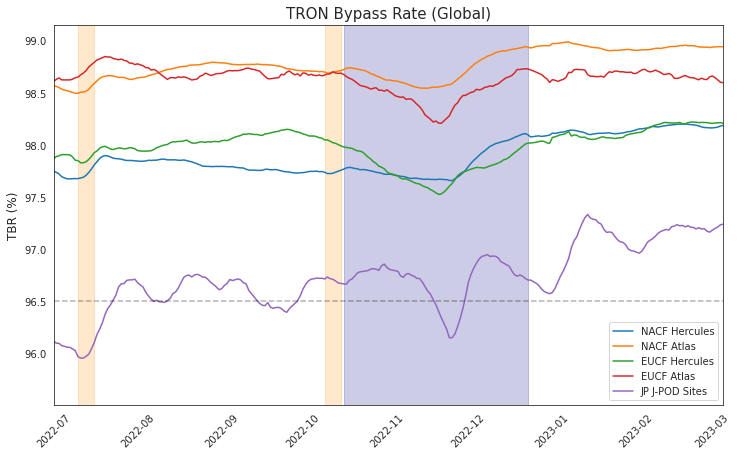

In [46]:
# Visualizing TBR Over Time (ORIGINAL GROUPINGS)

viz_df = main_df

plt.figure(figsize=(12,7))

sns.set_style('white')

plt.plot(viz_df[(viz_df['drive_type'].isin(['H'])) & (viz_df['region'].isin(['NA']))].groupby('pt_fc_date').mean().index,
         viz_df[(viz_df['drive_type'].isin(['H'])) & (viz_df['region'].isin(['NA']))].groupby('pt_fc_date').mean().tbr.rolling(window=7).mean(), 
         label='NACF Hercules')

plt.plot(viz_df[(viz_df['drive_type'].isin(['G'])) & (viz_df['region'].isin(['NA']))].groupby('pt_fc_date').mean().index,
         viz_df[(viz_df['drive_type'].isin(['G'])) & (viz_df['region'].isin(['NA']))].groupby('pt_fc_date').mean().tbr.rolling(window=7).mean(), 
         label='NACF Atlas')

plt.plot(viz_df[(viz_df['drive_type'].isin(['H'])) & (viz_df['region'].isin(['EU']))].groupby('pt_fc_date').mean().index,
         viz_df[(viz_df['drive_type'].isin(['H'])) & (viz_df['region'].isin(['EU']))].groupby('pt_fc_date').mean().tbr.rolling(window=7).mean(), 
         label='EUCF Hercules')

plt.plot(viz_df[(viz_df['drive_type'].isin(['G'])) & (viz_df['region'].isin(['EU']))].groupby('pt_fc_date').mean().index,
         viz_df[(viz_df['drive_type'].isin(['G'])) & (viz_df['region'].isin(['EU']))].groupby('pt_fc_date').mean().tbr.rolling(window=7).mean(), 
         label='EUCF Atlas')

plt.plot(viz_df[(viz_df['region'].isin(['NRT']))].groupby('pt_fc_date').mean().index,
         viz_df[(viz_df['region'].isin(['NRT']))].groupby('pt_fc_date').mean().tbr.rolling(window=7).mean(), 
         label='JP J-POD Sites')

plt.title('TRON Bypass Rate (Global)', fontsize = 15)
plt.ylabel('TBR (%)', fontsize = 12)
plt.xticks(rotation=45)
# 
# plt.axvspan(dt.datetime.strptime('2019-07-14', '%Y-%m-%d'),dt.datetime.strptime('2019-07-20', '%Y-%m-%d'), color='darkorange', alpha=.2, label='' )
# plt.axvspan(dt.datetime.strptime('2019-10-15', '%Y-%m-%d'),dt.datetime.strptime('2019-12-23', '%Y-%m-%d'), color='darkblue', alpha=.2, label='' )
# plt.axvspan(dt.datetime.strptime('2020-10-11', '%Y-%m-%d'),dt.datetime.strptime('2020-10-18', '%Y-%m-%d'), color='darkorange', alpha=.2, label='' )
# plt.axvspan(dt.datetime.strptime('2020-10-15', '%Y-%m-%d'),dt.datetime.strptime('2020-12-23', '%Y-%m-%d'), color='darkblue', alpha=.2, label='' )
# plt.axvspan(dt.datetime.strptime('2021-06-20', '%Y-%m-%d'),dt.datetime.strptime('2021-06-26', '%Y-%m-%d'), color='darkorange', alpha=.2, label='' )
# plt.axvspan(dt.datetime.strptime('2021-10-15', '%Y-%m-%d'),dt.datetime.strptime('2021-12-23', '%Y-%m-%d'), color='darkblue', alpha=.2, label='' )
plt.axvspan(dt.datetime.strptime('2022-07-10', '%Y-%m-%d'),dt.datetime.strptime('2022-07-16', '%Y-%m-%d'), color='darkorange', alpha=.2, label='' )
plt.axvspan(dt.datetime.strptime('2022-10-09', '%Y-%m-%d'),dt.datetime.strptime('2022-10-15', '%Y-%m-%d'), color='darkorange', alpha=.2, label='' )
plt.axvspan(dt.datetime.strptime('2022-10-16', '%Y-%m-%d'),dt.datetime.strptime('2022-12-23', '%Y-%m-%d'), color='darkblue', alpha=.2, label='' )
plt.axhline(96.5, color='black', linestyle = '--', label='', alpha = 0.3)

plt.legend(loc='lower right', ncol=(1), frameon = True)
plt.xlim(pd.to_datetime('2022-07-01'),pd.to_datetime('2023-03-05'))
# plt.ylim(95.9,97.5)

In [47]:
# Creating Month Field

main_df['fc_month'] = main_df['pt_fc_date'].dt.month

In [48]:
# Aggregating Upward for Volumes

agg_df = main_df[['fc_month', 'total_stows', 'lc_count', 'region',
               'drive_type']].groupby(['region', 'drive_type', 'fc_month']).sum().reset_index()

# Trimming to JUST X Month
agg_df = agg_df[agg_df['fc_month'] == 12]

agg_df

,region,drive_type,fc_month,total_stows,lc_count
11,EU,G,12,3.882322e+07,528166.0
23,EU,H,12,4.314987e+08,9006118.0
35,NA,G,12,3.634190e+08,3960754.0
47,NA,H,12,1.072852e+09,20947106.0
59,NRT,H,12,8.190304e+07,2649007.0


## Monitoring Fullness, Units per Face, Etc.

In [49]:
# Fetching Main TBR Dataframe
main_df = fetch_s3_from_file('TRON_Bypass_Modelling/TBR_model_data_raw.csv')
main_df = main_df.drop(['Unnamed: 0','Unnamed: 0.1','ML_Accuracy'], axis=1)

# Converting pt_fc_date to Datetime
main_df.pt_fc_date = pd.to_datetime(main_df['pt_fc_date'])

# Replacing NaN Value for North America with "NA"
main_df.region.fillna('NA', inplace=True)

# main_df.head()
main_df.shape

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/boto3/compat.py:88: PythonDeprecationWarning: Boto3 will no longer support Python 3.6 starting May 30, 2022. To continue receiving service updates, bug fixes, and security updates please upgrade to Python 3.7 or later. More information can be found here: https://aws.amazon.com/blogs/developer/python-support-policy-updates-for-aws-sdks-and-tools/
  warnings.warn(warning, PythonDeprecationWarning)


(81297, 43)

In [50]:
# Data Cleaning to get rid of impossible values
main_df = main_df.replace(float("inf"), np.nan)
main_df = main_df.replace([np.inf, -np.inf], np.nan)

# Checking which sites are included in the Dataframe
# main_df.building.unique()

In [51]:
# Chopping Early 2022 Out from NRT Dataframe (Unstable Metrics pre-Prime)

# na_eu = main_df[main_df['region'].isin(['NA','EU'])]
# nrt = main_df[(main_df['region'].isin(['NRT'])) & (main_df['pt_fc_date'] >= pd.to_datetime('2022-06-01'))]

# main_df = pd.concat([na_eu, nrt], ignore_index = True)
# main_df.shape

In [52]:
# Dropping Immature Sites (>120 Days since first transactions)

main_df = main_df[main_df['site_maturity'] == 1]
main_df.shape

(73015, 43)

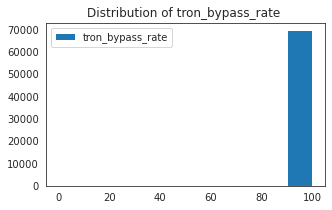

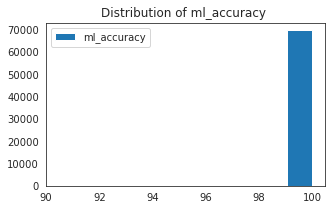

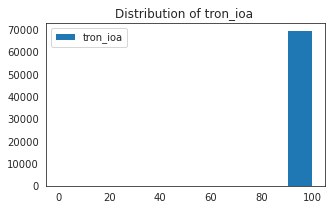

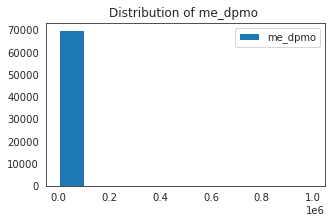

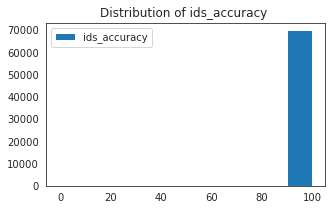

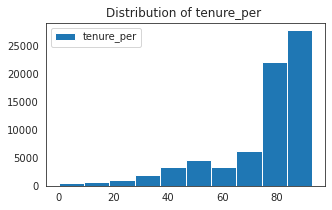

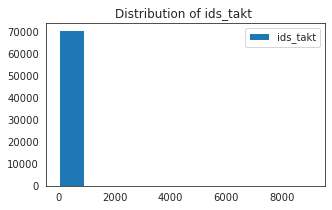

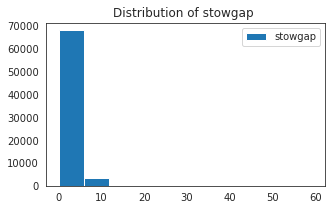

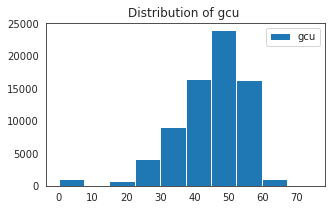

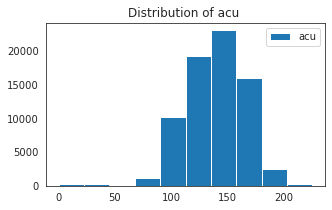

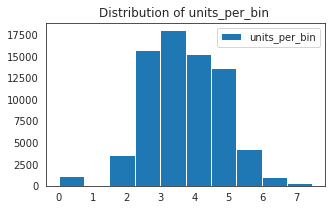

In [53]:
# Plotting Histograms to Determine Outlier Variables

for c in ['tron_bypass_rate', 'ml_accuracy', 'tron_ioa', 'me_dpmo', 'ids_accuracy',
          'tenure_per', 'ids_takt', 'stowgap', 'gcu', 'acu', 'units_per_bin']:
    
    fig = plt.figure(figsize=(5, 3))
    plt.hist(main_df[c], label=c) 
    plt.title(f"Distribution of {c} ")
    plt.legend()
    plt.show()

In [54]:
# Understanding the Distribution of these Variables

x_vars = ['tron_bypass_rate', 'ml_accuracy', 'tron_ioa', 'me_dpmo', 'ids_accuracy',
          'tenure_per', 'ids_takt', 'units_per_face', 'stowgap', 'gcu', 'acu', 'units_per_bin']

main_df[x_vars].describe()

,tron_bypass_rate,ml_accuracy,tron_ioa,me_dpmo,ids_accuracy,tenure_per,ids_takt,units_per_face,stowgap,gcu,acu,units_per_bin
count,69735.000000,69735.000000,69735.000000,69735.000000,69735.000000,71592.000000,70401.000000,71590.000000,71708.000000,72923.000000,72902.000000,72923.000000
mean,97.637569,99.967126,98.954871,284.531292,99.914844,73.967848,15.584467,8.143987,2.416755,44.540074,139.028469,3.703753
std,2.320377,0.112189,1.290524,3793.857294,0.403243,17.871751,42.126753,2.556996,1.861983,10.495540,26.837465,1.134565
min,0.000000,90.476190,0.000000,0.000000,-0.700000,0.000000,0.000000,0.340048,0.000000,0.000000,0.229705,0.000000
25%,97.312396,99.959227,98.551963,176.898119,99.901938,70.094414,13.487877,6.341550,1.160688,38.817315,120.070403,2.888614
50%,97.849628,100.000000,99.146341,232.980024,99.942265,81.914861,15.160547,7.788890,1.919326,46.562965,141.381663,3.649934
75%,98.320530,100.000000,99.728997,317.095109,99.965054,85.530443,16.972522,9.655863,3.140574,52.044394,158.592156,4.555348
max,100.000000,100.000000,100.000000,1000000.000000,100.000000,93.032787,9072.899000,39.657837,59.280655,74.701864,225.565295,7.476528


In [55]:
# Setting Data Limits for the "Cleaned" Dataframe

# Scrubbing Data from main_df
df_clean = main_df

# IDS KPIs
min_tbr = 90.0
min_ml_accuracy = 99.7
min_ioa = 95.0
max_me_dpmo = 1200
min_ids_accuracy = 99.0

df_clean = df_clean[df_clean['tron_bypass_rate'] >= min_tbr]
df_clean = df_clean[df_clean['ml_accuracy'] >= min_ml_accuracy]
df_clean = df_clean[df_clean['tron_ioa'] >= min_ioa]
df_clean = df_clean[df_clean['me_dpmo'] <= max_me_dpmo]
df_clean = df_clean[df_clean['ids_accuracy'] >= min_ids_accuracy]

# Other Metrics
max_ids_takt = 40
max_podgap = 20
max_acu = 250

df_clean = df_clean[df_clean['ids_takt'] <= max_ids_takt]
df_clean = df_clean[df_clean['stowgap'] <= max_podgap]
df_clean = df_clean[df_clean['acu'] <= max_acu]

# Dropping Unnecessary Values
df_clean = df_clean.drop_duplicates()
df_clean = df_clean.dropna()

# Determining how much data was cut in cleaning
print(round((len(main_df)-len(df_clean))/len(main_df)*100,2), '% removed during cleaning')

10.62 % removed during cleaning


In [56]:
# Resetting Main DF to be the newly Cleaned DF

main_df = df_clean

(19024.0, 19421.0)

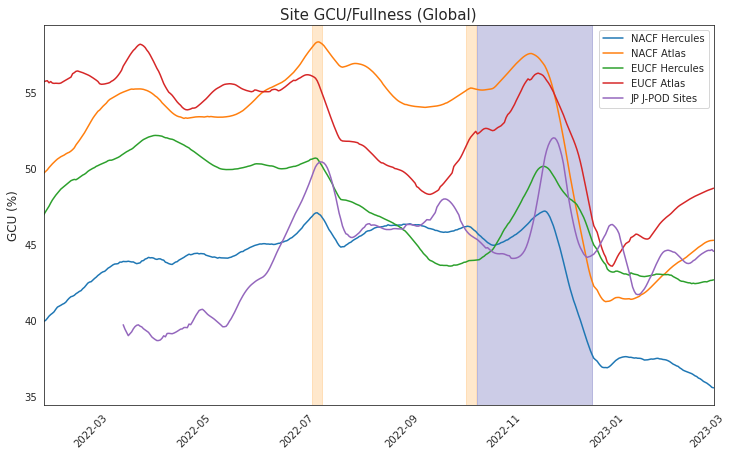

In [61]:
# Visualizing GCU/Fullness Over Time (ORIGINAL GROUPINGS)

viz_df = main_df

plt.figure(figsize=(12,7))

sns.set_style('white')

plt.plot(viz_df[(viz_df['drive_type'].isin(['H'])) & (viz_df['region'].isin(['NA']))].groupby('pt_fc_date').mean().index,
         viz_df[(viz_df['drive_type'].isin(['H'])) & (viz_df['region'].isin(['NA']))].groupby('pt_fc_date').mean().gcu.rolling(window=14).mean(), 
         label='NACF Hercules')

plt.plot(viz_df[(viz_df['drive_type'].isin(['G'])) & (viz_df['region'].isin(['NA']))].groupby('pt_fc_date').mean().index,
         viz_df[(viz_df['drive_type'].isin(['G'])) & (viz_df['region'].isin(['NA']))].groupby('pt_fc_date').mean().gcu.rolling(window=14).mean(), 
         label='NACF Atlas')

plt.plot(viz_df[(viz_df['drive_type'].isin(['H'])) & (viz_df['region'].isin(['EU']))].groupby('pt_fc_date').mean().index,
         viz_df[(viz_df['drive_type'].isin(['H'])) & (viz_df['region'].isin(['EU']))].groupby('pt_fc_date').mean().gcu.rolling(window=14).mean(), 
         label='EUCF Hercules')

plt.plot(viz_df[(viz_df['drive_type'].isin(['G'])) & (viz_df['region'].isin(['EU']))].groupby('pt_fc_date').mean().index,
         viz_df[(viz_df['drive_type'].isin(['G'])) & (viz_df['region'].isin(['EU']))].groupby('pt_fc_date').mean().gcu.rolling(window=14).mean(), 
         label='EUCF Atlas')

plt.plot(viz_df[(viz_df['region'].isin(['NRT']))].groupby('pt_fc_date').mean().index,
         viz_df[(viz_df['region'].isin(['NRT']))].groupby('pt_fc_date').mean().gcu.rolling(window=14).mean(), 
         label='JP J-POD Sites')

plt.title('Site GCU/Fullness (Global)', fontsize = 15)
plt.ylabel('GCU (%)', fontsize = 12)
plt.xticks(rotation=45)
# 
# plt.axvspan(dt.datetime.strptime('2019-07-14', '%Y-%m-%d'),dt.datetime.strptime('2019-07-20', '%Y-%m-%d'), color='darkorange', alpha=.2, label='' )
# plt.axvspan(dt.datetime.strptime('2019-10-15', '%Y-%m-%d'),dt.datetime.strptime('2019-12-23', '%Y-%m-%d'), color='darkblue', alpha=.2, label='' )
# plt.axvspan(dt.datetime.strptime('2020-10-11', '%Y-%m-%d'),dt.datetime.strptime('2020-10-18', '%Y-%m-%d'), color='darkorange', alpha=.2, label='' )
# plt.axvspan(dt.datetime.strptime('2020-10-15', '%Y-%m-%d'),dt.datetime.strptime('2020-12-23', '%Y-%m-%d'), color='darkblue', alpha=.2, label='' )
# plt.axvspan(dt.datetime.strptime('2021-06-20', '%Y-%m-%d'),dt.datetime.strptime('2021-06-26', '%Y-%m-%d'), color='darkorange', alpha=.2, label='' )
# plt.axvspan(dt.datetime.strptime('2021-10-15', '%Y-%m-%d'),dt.datetime.strptime('2021-12-23', '%Y-%m-%d'), color='darkblue', alpha=.2, label='' )
plt.axvspan(dt.datetime.strptime('2022-07-10', '%Y-%m-%d'),dt.datetime.strptime('2022-07-16', '%Y-%m-%d'), color='darkorange', alpha=.2, label='' )
plt.axvspan(dt.datetime.strptime('2022-10-09', '%Y-%m-%d'),dt.datetime.strptime('2022-10-15', '%Y-%m-%d'), color='darkorange', alpha=.2, label='' )
plt.axvspan(dt.datetime.strptime('2022-10-16', '%Y-%m-%d'),dt.datetime.strptime('2022-12-23', '%Y-%m-%d'), color='darkblue', alpha=.2, label='' )

plt.legend(loc='best', ncol=(1), frameon = True)
plt.xlim(pd.to_datetime('2022-02-01'),pd.to_datetime('2023-03-05'))
# plt.ylim(95.9,97.5)

## Month-Over-Month IDS Model Data, Visuals

In [137]:
# Fetching Main TBR Dataframe
main_df = fetch_s3_from_file('TRON_Bypass_Modelling/TBR_model_data_raw.csv')
main_df = main_df.drop(['Unnamed: 0','ML_Accuracy'], axis=1)

# Converting pt_fc_date to Datetime
main_df.pt_fc_date = pd.to_datetime(main_df['pt_fc_date'])

# Replacing NaN Value for North America with "NA"
main_df.region.fillna('NA', inplace=True)

# main_df.head()
main_df.shape

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/boto3/compat.py:88: PythonDeprecationWarning: Boto3 will no longer support Python 3.6 starting May 30, 2022. To continue receiving service updates, bug fixes, and security updates please upgrade to Python 3.7 or later. More information can be found here: https://aws.amazon.com/blogs/developer/python-support-policy-updates-for-aws-sdks-and-tools/
  warnings.warn(warning, PythonDeprecationWarning)


(89723, 43)

In [138]:
# Data Cleaning to get rid of impossible values
main_df = main_df.replace(float("inf"), np.nan)
main_df = main_df.replace([np.inf, -np.inf], np.nan)

# Checking which sites are included in the Dataframe
# main_df.building.unique()

In [139]:
# Chopping Early 2022 Out from NRT Dataframe (Unstable Metrics pre-Prime)

na_eu = main_df[main_df['region'].isin(['NA','EU'])]
nrt = main_df[(main_df['region'].isin(['NRT'])) & (main_df['pt_fc_date'] >= pd.to_datetime('2022-06-01'))]
nrt = nrt[(nrt['site'].isin(['KIX5','QCB1','KIX6','TYO1','TYO4','TYO6','TYO7','TYO8','TYO9']))] # J-POD Sites

main_df = pd.concat([na_eu, nrt], ignore_index = True)
main_df.shape

(87059, 43)

In [140]:
# Dropping Immature Sites (>120 Days since first transactions)

main_df = main_df[main_df['site_maturity'] == 1]
main_df.shape

(78924, 43)

In [141]:
# Understanding the Distribution of these Variables

x_vars = ['tron_bypass_rate', 'ml_accuracy', 'tron_ioa', 'me_dpmo', 'ids_accuracy',
          'tenure_per', 'ids_takt', 'units_per_face', 'stowgap', 'gcu', 'acu', 'units_per_bin']

main_df[x_vars].describe()

,tron_bypass_rate,ml_accuracy,tron_ioa,me_dpmo,ids_accuracy,tenure_per,ids_takt,units_per_face,stowgap,gcu,acu,units_per_bin
count,75793.000000,75793.000000,75793.000000,75793.000000,75793.000000,76369.000000,75446.000000,76367.000000,77204.000000,78832.000000,78815.000000,78832.000000
mean,97.693935,99.968836,98.942692,277.219901,99.917325,70.107898,15.532903,8.207990,2.378243,43.977489,139.543869,3.637252
std,1.802180,0.108810,1.296409,3640.516814,0.387734,21.261431,40.684972,2.567810,1.804978,10.599100,26.210158,1.112175
min,0.000000,90.476191,0.000000,0.000000,-0.700000,0.000000,0.000000,0.340048,0.000000,0.000053,8.104477,0.000000
25%,97.346278,99.961671,98.534799,172.377375,99.904643,56.687525,13.439820,6.394429,1.151772,38.202370,120.769717,2.852936
50%,97.875145,100.000000,99.132948,227.454869,99.944229,80.676713,15.101883,7.856590,1.885953,45.661354,141.914502,3.570775
75%,98.346612,100.000000,99.717514,310.919437,99.966196,85.092516,16.909607,9.736396,3.079186,51.662381,158.672790,4.429017
max,100.000000,100.000000,100.000000,1000000.000000,100.000000,93.032787,9072.899000,39.657837,55.956984,74.701864,225.565295,7.476528


In [142]:
# Setting Data Limits for the "Cleaned" Dataframe

# Scrubbing Data from main_df
df_clean = main_df

# IDS KPIs
min_tbr = 90.0
min_ml_accuracy = 99.7
min_ioa = 95.0
max_me_dpmo = 1200
min_ids_accuracy = 99.0

df_clean = df_clean[df_clean['tron_bypass_rate'] >= min_tbr]
df_clean = df_clean[df_clean['ml_accuracy'] >= min_ml_accuracy]
df_clean = df_clean[df_clean['tron_ioa'] >= min_ioa]
df_clean = df_clean[df_clean['me_dpmo'] <= max_me_dpmo]
df_clean = df_clean[df_clean['ids_accuracy'] >= min_ids_accuracy]

# Other Metrics
max_ids_takt = 40
max_podgap = 20
max_acu = 250

df_clean = df_clean[df_clean['ids_takt'] <= max_ids_takt]
df_clean = df_clean[df_clean['stowgap'] <= max_podgap]
df_clean = df_clean[df_clean['acu'] <= max_acu]

# Dropping Unnecessary Values
df_clean = df_clean.drop_duplicates()
df_clean = df_clean.dropna()

# Determining how much data was cut in cleaning
print(round((len(main_df)-len(df_clean))/len(main_df)*100,2), '% removed during cleaning')

11.03 % removed during cleaning


In [143]:
# Resetting Main DF to be the newly Cleaned DF

main_df = df_clean

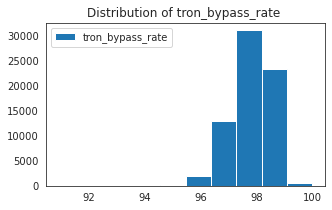

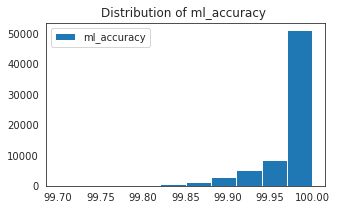

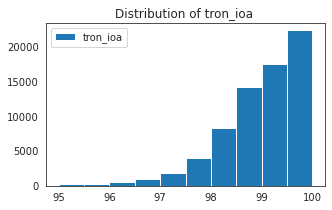

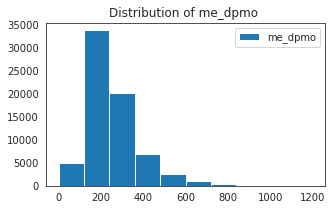

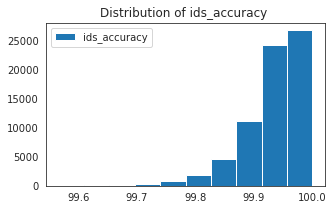

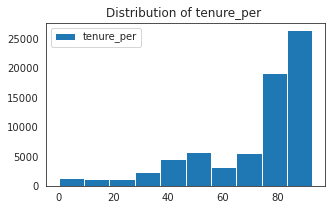

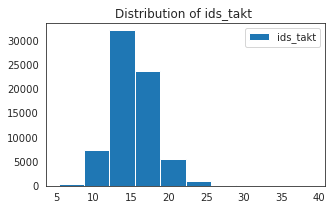

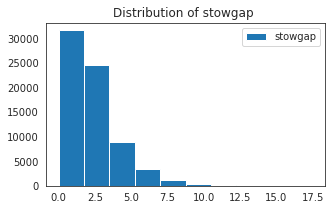

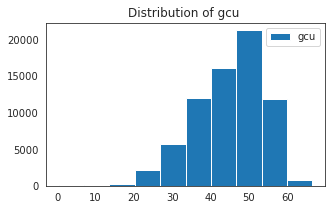

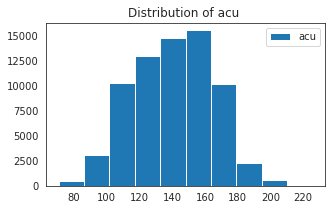

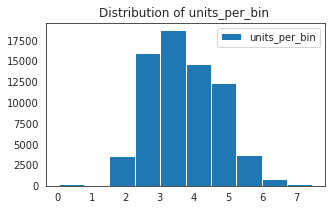

In [144]:
# Plotting Histograms following DF Cleaning (i.e. much more normal curves)

for c in ['tron_bypass_rate', 'ml_accuracy', 'tron_ioa', 'me_dpmo', 'ids_accuracy',
          'tenure_per', 'ids_takt', 'stowgap', 'gcu', 'acu', 'units_per_bin']:
    
    fig = plt.figure(figsize=(5,3))
    plt.hist(main_df[c], label=c) 
    plt.title(f"Distribution of {c} ")
    plt.legend()
    plt.show()

## Creating Month over Month Data

In [145]:
main_df.columns

Index(['site', 'pt_fc_date', 'total_stows', 'hc_agreements', 'hc_audits',
       'hc_count', 'lc_agreements', 'lc_audits', 'lc_count', 'multiple_events',
       'tron_bypass_rate', 'tron_ioa', 'me_dpmo', 'ml_accuracy',
       'ids_accuracy', 'me_pct', 'ib_volume', 'stow_hrs', 'vet_hrs',
       'stow_work_secs', 'stows_performed', 'IDS_work_secs',
       'IDS_stows_performed', 'pod_visits', 'units_per_face', 'tenure_per',
       'ids_takt', 'stow_gap_ms', 'stow_total_ms', 'stowgap', 'units', 'bins',
       'inventory_volume', 'gross_volume', 'gcu', 'acu', 'units_per_bin',
       'region', 'building_type', 'drive_type', 'pick_start', 'launch_year',
       'site_maturity'],
      dtype='object')

In [146]:
# Creating Month and Year Columns to Aggregate toward

main_df['month'] = main_df['pt_fc_date'].dt.month
main_df['year'] = main_df['pt_fc_date'].dt.year

In [147]:
# Aggregating Upward by Month and Year per Region/Drive type

agg_df = main_df.groupby(['region', 'drive_type', 'year', 'month']).agg(
    {'total_stows': 'sum',
     'hc_agreements': 'sum',
     'hc_audits': 'sum',
     'hc_count': 'sum',
     'lc_agreements': 'sum',
     'lc_audits': 'sum',
     'lc_count': 'sum',
     'multiple_events': 'sum',
     'ml_accuracy': 'mean',
     'ib_volume': 'sum',
     'stow_hrs': 'sum',
     'vet_hrs': 'sum',
     'stow_work_secs': 'sum',
     'stows_performed': 'sum',
     'IDS_work_secs': 'sum',
     'IDS_stows_performed': 'sum',
     'pod_visits': 'sum',
     'stow_gap_ms': 'sum',
     'stow_total_ms': 'sum',
     'units': 'sum',
     'bins': 'sum',
     'inventory_volume': 'sum',
     'gross_volume': 'sum'}).reset_index()

agg_df.head()

,region,drive_type,year,month,total_stows,hc_agreements,hc_audits,hc_count,lc_agreements,lc_audits,...,stows_performed,IDS_work_secs,IDS_stows_performed,pod_visits,stow_gap_ms,stow_total_ms,units,bins,inventory_volume,gross_volume
0,EU,G,2022,1,37335109.0,109463.0,109478.0,36729693.0,21354.0,21551.0,...,4.831018e+09,6.840150e+10,4.666387e+09,9.211583e+08,2.384655e+10,5.213720e+11,92619559.0,16576901.0,9.378189e+09,1.829066e+10
1,EU,G,2022,2,32425208.0,68050.0,68055.0,31922700.0,8973.0,9080.0,...,3.994753e+09,6.035380e+10,3.889226e+09,8.591264e+08,2.146942e+10,4.643880e+11,87687341.0,15319153.0,9.271370e+09,1.690293e+10
2,EU,G,2022,3,39888159.0,119864.0,119883.0,39251967.0,11042.0,11188.0,...,4.810624e+09,7.727550e+10,4.643430e+09,1.178777e+09,2.822354e+10,5.920709e+11,98001830.0,16805950.0,1.048574e+10,1.854320e+10
3,EU,G,2022,4,28675690.0,133915.0,133932.0,28255662.0,17532.0,17760.0,...,4.058724e+09,5.980707e+10,3.907324e+09,8.247552e+08,1.398121e+10,4.131351e+11,90103683.0,15924911.0,9.523628e+09,1.757113e+10
4,EU,G,2022,5,33990522.0,158357.0,158371.0,33484211.0,26758.0,27063.0,...,4.727638e+09,7.047211e+10,4.565970e+09,1.038440e+09,2.191553e+10,4.874664e+11,97399899.0,17377327.0,1.041500e+10,1.917387e+10


In [148]:
# Recalc Key Metrics

# Stow KPIs
agg_df['units_per_face'] = agg_df['ib_volume'] / agg_df['pod_visits']
agg_df['tenure_per'] = agg_df['vet_hrs'] / agg_df['stow_hrs'] *100
agg_df['ids_takt'] = agg_df['IDS_work_secs'] / agg_df['IDS_stows_performed']

# IDS KPIs
agg_df['tron_bypass_rate'] = agg_df['hc_count'] / agg_df['total_stows']
agg_df['tron_ioa'] = agg_df['lc_agreements'] / agg_df['lc_audits']
agg_df['me_dpmo'] = agg_df['multiple_events'] / agg_df['total_stows'] *1000000
agg_df['ml_accuracy'] = agg_df['ml_accuracy'] / 100

In [149]:
# Recalculating IDS System Accuracy
agg_df['ids_accuracy'] = (agg_df['tron_bypass_rate'] * agg_df['ml_accuracy'] + (1 - agg_df['tron_bypass_rate']) * 
                       agg_df['tron_ioa'] - agg_df['me_dpmo']/1000000) *100

In [150]:
# Scaling all IDS % KPIs up by 100 for Modelling

agg_df['tron_bypass_rate'] = agg_df['tron_bypass_rate'] *100
agg_df['tron_ioa'] = agg_df['tron_ioa'] *100
agg_df['ml_accuracy'] = agg_df['ml_accuracy'] *100
agg_df['me_pct'] = agg_df['multiple_events'] / agg_df['total_stows'] *100 # Creating a more stable ME % metric

In [151]:
# GCU Metrics
agg_df['units_per_bin'] = agg_df['units'] / agg_df['bins']
agg_df['gcu'] = agg_df['inventory_volume'] / agg_df['gross_volume']*100
agg_df['acu'] = agg_df['inventory_volume'] / agg_df['units']

# Stow Podgap
agg_df['stowgap'] = agg_df['stow_gap_ms'] / agg_df['stow_total_ms'] *100

agg_df.columns

Index(['region', 'drive_type', 'year', 'month', 'total_stows', 'hc_agreements',
       'hc_audits', 'hc_count', 'lc_agreements', 'lc_audits', 'lc_count',
       'multiple_events', 'ml_accuracy', 'ib_volume', 'stow_hrs', 'vet_hrs',
       'stow_work_secs', 'stows_performed', 'IDS_work_secs',
       'IDS_stows_performed', 'pod_visits', 'stow_gap_ms', 'stow_total_ms',
       'units', 'bins', 'inventory_volume', 'gross_volume', 'units_per_face',
       'tenure_per', 'ids_takt', 'tron_bypass_rate', 'tron_ioa', 'me_dpmo',
       'ids_accuracy', 'me_pct', 'units_per_bin', 'gcu', 'acu', 'stowgap'],
      dtype='object')

In [152]:
# Reorganizing the DF According to the Modelling

final_df = agg_df[['region', 'drive_type', 'year', 'month', 'tron_bypass_rate', 'ml_accuracy', 'tron_ioa', 'me_dpmo',
                   'ids_accuracy', 'tenure_per', 'ids_takt', 'units_per_face', 'stowgap', 'gcu', 'acu', 'units_per_bin',
                   'total_stows']]

final_df.head()

,region,drive_type,year,month,tron_bypass_rate,ml_accuracy,tron_ioa,me_dpmo,ids_accuracy,tenure_per,ids_takt,units_per_face,stowgap,gcu,acu,units_per_bin,total_stows
0,EU,G,2022,1,98.378427,99.990149,99.085889,369.973475,99.938488,79.488808,14.658342,5.244336,4.573808,51.273118,101.254954,5.587266,37335109.0
1,EU,G,2022,2,98.450255,99.991855,98.821586,349.203620,99.938799,78.122217,15.518205,4.650367,4.623163,54.850679,105.732140,5.724033,32425208.0
2,EU,G,2022,3,98.405061,99.988860,98.695030,365.923130,99.931632,78.648471,16.641902,4.081065,4.766919,56.547599,106.995311,5.831377,39888159.0
3,EU,G,2022,4,98.535247,99.990652,98.716216,324.037538,99.939581,80.329593,15.306402,4.920789,3.384173,54.200425,105.696327,5.658034,28675690.0
4,EU,G,2022,5,98.510435,99.984593,98.873000,374.016027,99.930634,80.762408,15.434204,4.552722,4.495802,54.318724,106.930329,5.604999,33990522.0


In [153]:
# Exporting the Dataframe for Use in the Model Notebook
write_results_s3(final_df,'cotezach-prod','TRON_Bypass_Modelling/TBR_model_data_monthbymonth.csv')

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/boto3/compat.py:88: PythonDeprecationWarning: Boto3 will no longer support Python 3.6 starting May 30, 2022. To continue receiving service updates, bug fixes, and security updates please upgrade to Python 3.7 or later. More information can be found here: https://aws.amazon.com/blogs/developer/python-support-policy-updates-for-aws-sdks-and-tools/
  warnings.warn(warning, PythonDeprecationWarning)


## Creating IDS TBR Visuals

(19266.0, 19457.0)

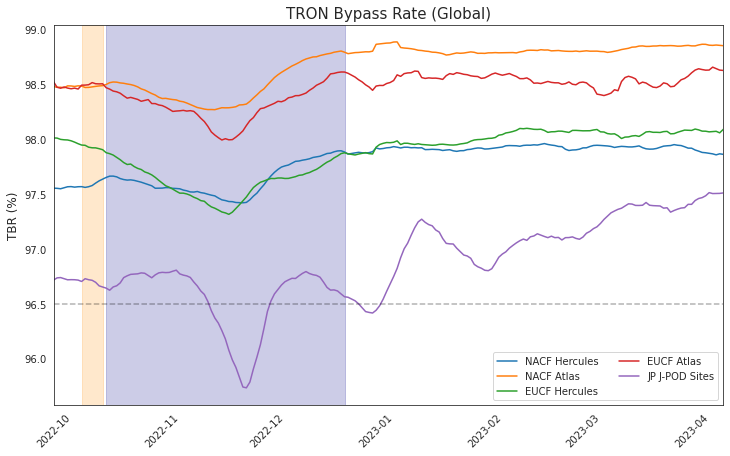

In [154]:
# Visualizing TBR Over Time (ORIGINAL GROUPINGS)

viz_df = main_df

plt.figure(figsize=(12,7))

sns.set_style('white')

plt.plot(viz_df[(viz_df['drive_type'].isin(['H'])) & (viz_df['region'].isin(['NA']))].groupby('pt_fc_date').mean().index,
         viz_df[(viz_df['drive_type'].isin(['H'])) & (viz_df['region'].isin(['NA']))].groupby('pt_fc_date').mean().tron_bypass_rate.rolling(window=7).mean(), 
         label='NACF Hercules')

plt.plot(viz_df[(viz_df['drive_type'].isin(['G'])) & (viz_df['region'].isin(['NA']))].groupby('pt_fc_date').mean().index,
         viz_df[(viz_df['drive_type'].isin(['G'])) & (viz_df['region'].isin(['NA']))].groupby('pt_fc_date').mean().tron_bypass_rate.rolling(window=7).mean(), 
         label='NACF Atlas')

plt.plot(viz_df[(viz_df['drive_type'].isin(['H'])) & (viz_df['region'].isin(['EU']))].groupby('pt_fc_date').mean().index,
         viz_df[(viz_df['drive_type'].isin(['H'])) & (viz_df['region'].isin(['EU']))].groupby('pt_fc_date').mean().tron_bypass_rate.rolling(window=7).mean(), 
         label='EUCF Hercules')

plt.plot(viz_df[(viz_df['drive_type'].isin(['G'])) & (viz_df['region'].isin(['EU']))].groupby('pt_fc_date').mean().index,
         viz_df[(viz_df['drive_type'].isin(['G'])) & (viz_df['region'].isin(['EU']))].groupby('pt_fc_date').mean().tron_bypass_rate.rolling(window=7).mean(), 
         label='EUCF Atlas')

plt.plot(viz_df[(viz_df['region'].isin(['NRT']))].groupby('pt_fc_date').mean().index,
         viz_df[(viz_df['region'].isin(['NRT']))].groupby('pt_fc_date').mean().tron_bypass_rate.rolling(window=7).mean(), 
         label='JP J-POD Sites')

plt.title('TRON Bypass Rate (Global)', fontsize = 15)
plt.ylabel('TBR (%)', fontsize = 12)
plt.xticks(rotation=45)
# 
# plt.axvspan(dt.datetime.strptime('2019-07-14', '%Y-%m-%d'),dt.datetime.strptime('2019-07-20', '%Y-%m-%d'), color='darkorange', alpha=.2, label='' )
# plt.axvspan(dt.datetime.strptime('2019-10-15', '%Y-%m-%d'),dt.datetime.strptime('2019-12-23', '%Y-%m-%d'), color='darkblue', alpha=.2, label='' )
# plt.axvspan(dt.datetime.strptime('2020-10-11', '%Y-%m-%d'),dt.datetime.strptime('2020-10-18', '%Y-%m-%d'), color='darkorange', alpha=.2, label='' )
# plt.axvspan(dt.datetime.strptime('2020-10-15', '%Y-%m-%d'),dt.datetime.strptime('2020-12-23', '%Y-%m-%d'), color='darkblue', alpha=.2, label='' )
# plt.axvspan(dt.datetime.strptime('2021-06-20', '%Y-%m-%d'),dt.datetime.strptime('2021-06-26', '%Y-%m-%d'), color='darkorange', alpha=.2, label='' )
# plt.axvspan(dt.datetime.strptime('2021-10-15', '%Y-%m-%d'),dt.datetime.strptime('2021-12-23', '%Y-%m-%d'), color='darkblue', alpha=.2, label='' )
plt.axvspan(dt.datetime.strptime('2022-07-10', '%Y-%m-%d'),dt.datetime.strptime('2022-07-16', '%Y-%m-%d'), color='darkorange', alpha=.2, label='' )
plt.axvspan(dt.datetime.strptime('2022-10-09', '%Y-%m-%d'),dt.datetime.strptime('2022-10-15', '%Y-%m-%d'), color='darkorange', alpha=.2, label='' )
plt.axvspan(dt.datetime.strptime('2022-10-16', '%Y-%m-%d'),dt.datetime.strptime('2022-12-23', '%Y-%m-%d'), color='darkblue', alpha=.2, label='' )
plt.axhline(96.5, color='black', linestyle = '--', label='', alpha = 0.3)

plt.legend(loc='lower right', ncol=(2), frameon = True)
plt.xlim(pd.to_datetime('2022-10-01'),pd.to_datetime('2023-04-10'))
# plt.ylim(95.9,97.5)